# Logistic regression

We will again solve the MNIST handwritten image recognition problem.

In [1]:
#Common imports
import numpy as np
from pprint import pprint 

#to make this notebook's output stable across runs
np.random.seed(42)

#Sklearn specfic imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

#scipy 
from scipy.stats import loguniform

#To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))


In [2]:
# Ignore all warning by sklearn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Handwritten Digit Classification

In [3]:
# get data
from sklearn.datasets import fetch_openml

X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True) 

In [4]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

## Visualisation

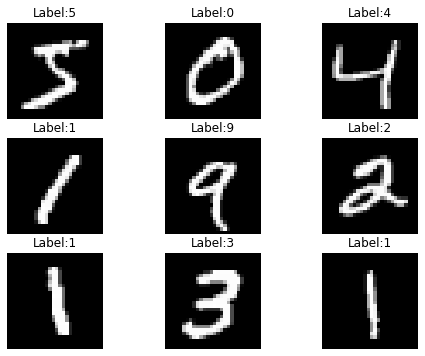

In [7]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y[index + j])))
        ax[i, j].set_axis_off()

## Pre-Processing

* Unlike perceptron, where scaling is optional, sigmoid requires scaling between 0 and 1
* Do not apply mean centering as it removes zeros from the data. Zeros should be kept as zeros in the data.
* we are not using pipeline, since there is just the one preprocessing step.

In [6]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Data Splitting

In [8]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Checking for imbalance

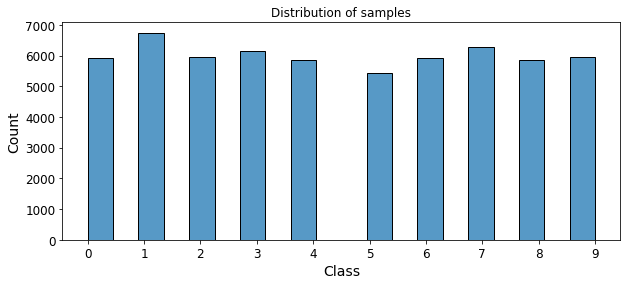

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data = np.int8(y_train), binwidth = 0.45, bins = 11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary classifcation: 0-detector

In [15]:
# Initialize new variable names with all 1
y_train_0 = np.zeros((len(y_train)))
y_test_0 =  np.zeros((len(y_test)))

#find indices of the digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### Sanity check

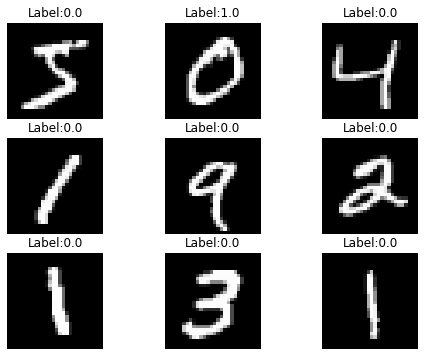

In [16]:

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y_train_0[index + j])))
        ax[i, j].set_axis_off()

In [19]:
print(np.where(y_train=='0'))
print(np.where(y_train_0==1))

(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)
(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)


### Baseline Model


Let's quickly construct a baseline model witht he following rule

1. Count the number of samples per class
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.